## Ejercicio 5

Modificar el programa para que funcione para resolver problemas de regresión 
1. Debe modificarse la función de pérdida y sus derivadas, utilizando por ejemplo MSE
2. Debe crearse un generador de datos nuevo para que genere datos continuos (pueden mantenerse igualmente 2 entradas; en caso de usar más entradas puede requerirse más capas en la red neuronal)


In [159]:
#Importacion de librerias
import numpy as np
import matplotlib.pyplot as plt

Ahora ya no se generan datos aleatorios que deberemos clasificar por su clase, ya que no utilizaremos la red neuronal para clasificar. Lo que haremos ahora es generar puntos aleatorios mediante una distribucion uniforme, los cuales son las variables independientes de una funcion tridimensional que nosotros definiremos. Luego, la red neuronal debera aprender a predecir el valor de la funcion en cada punto, es decir, la variable dependiente.

In [160]:
def generaradorContinuo(cantidad_ejemplos):
    # Genero los valores de x1 y x2, las cuales son las variables independientes de la funcion que queremos aproximar
    x1 = np.random.uniform(0, 10, cantidad_ejemplos)
    x2 = np.random.uniform(0, 10, cantidad_ejemplos)
    x = np.c_[x1, x2]
    # Genero los valores de t, la cual es la variable dependiente de la funcion que queremos aproximar
    # En este caso vamos a usar una funcion de un paraboloide hiperbolico y un paraboloide eliptico (vamos a probar los 2, simplemente se cambia el signo)
    a=2
    b=2
    h=5
    k=5
    t = (((np.power(x1-h,2))/(np.power(a,2))) + (np.power(x2-k,2)/(np.power(b,2))))/2*0.5

    t = np.reshape(t, (cantidad_ejemplos,1)) #Para no obtener un error luego

    return x, t

En el codigo base se modifica:
1. La funcion de loss
2. Las derivadas del proceso de backpropagation
3. El learning rate se disminuye de 1 a 0.01 debido a que si no los valores de loss no disminuyen y la red funciona mal

### Codigo base con ciertas modificaciones

In [161]:


# Generador basado en ejemplo del curso CS231 de Stanford: 
# CS231n Convolutional Neural Networks for Visual Recognition
# (https://cs231n.github.io/neural-networks-case-study/)
def generar_datos_clasificacion(cantidad_ejemplos, cantidad_clases):
    FACTOR_ANGULO = 0.79
    AMPLITUD_ALEATORIEDAD = 0.1

    # Calculamos la cantidad de puntos por cada clase, asumiendo la misma cantidad para cada 
    # una (clases balanceadas)
    n = int(cantidad_ejemplos / cantidad_clases)

    # Entradas: 2 columnas (x1 y x2)
    x = np.zeros((cantidad_ejemplos, 2))
    
    # Salida deseada ("target"): 1 columna que contendra la clase correspondiente (codificada como un entero)
    t = np.zeros(cantidad_ejemplos, dtype="uint8")  # 1 columna: la clase correspondiente (t -> "target")
    
    randomgen = np.random.default_rng()

    # Por cada clase (que va de 0 a cantidad_clases)...
    for clase in range(cantidad_clases):
        # Tomando la ecuacion parametrica del circulo (x = r * cos(t), y = r * sin(t)), generamos 
        # radios distribuidos uniformemente entre 0 y 1 para la clase actual, y agregamos un poco de
        # aleatoriedad
        radios = np.linspace(0, 1, n) + AMPLITUD_ALEATORIEDAD * randomgen.standard_normal(size=n)

        # ... y angulos distribuidos tambien uniformemente, con un desfasaje por cada clase
        angulos = np.linspace(clase * np.pi * FACTOR_ANGULO, (clase + 1) * np.pi * FACTOR_ANGULO, n)

        # Generamos un rango con los subindices de cada punto de esta clase. Este rango se va
        # desplazando para cada clase: para la primera clase los indices estan en [0, n-1], para
        # la segunda clase estan en [n, (2 * n) - 1], etc.
        indices = range(clase * n, (clase + 1) * n)

        # Generamos las "entradas", los valores de las variables independientes. Las variables:
        # radios, angulos e indices tienen n elementos cada una, por lo que le estamos agregando
        # tambien n elementos a la variable x (que incorpora ambas entradas, x1 y x2)
        x1 = radios * np.sin(angulos)
        x2 = radios * np.cos(angulos)
        x[indices] = np.c_[x1, x2] #Esta función une al vector x1 y a x2. Es como que genera una matriz.

        # Guardamos el valor de la clase que le vamos a asociar a las entradas x1 y x2 que acabamos
        # de generar
        t[indices] = clase

    return x, t


def inicializar_pesos(n_entrada, n_capa_2, n_capa_3):
    randomgen = np.random.default_rng()

    #w son los pesos, b son los sesgos. En este caso tenemos 2 capas luego de la capa de entrada
    
    #Se inicializan con un valor bajo. Por eso se multiplilcan por 0.1
    w1 = 0.1 * randomgen.standard_normal((n_entrada, n_capa_2))
    b1 = 0.1 * randomgen.standard_normal((1, n_capa_2))

    w2 = 0.1 * randomgen.standard_normal((n_capa_2, n_capa_3))
    b2 = 0.1 * randomgen.standard_normal((1,n_capa_3))

    return {"w1": w1, "b1": b1, "w2": w2, "b2": b2}


def ejecutar_adelante(x, pesos):
    # Funcion de entrada (a.k.a. "regla de propagacion") para la primera capa oculta
    z = x.dot(pesos["w1"]) + pesos["b1"]
    #Por más que b1 sea un vector y la multiplicación de x*w sea una matriz, como tienen la misma cantidad de columnas, se puede hacer la suma porque numpy intuye que queremos sumar a cada fila de la matriz el mismo vector b.

    # Funcion de activacion ReLU para la capa oculta (h -> "hidden")
    h = np.maximum(0, z)
    #Esta función de activación convierte a 0 los valores negativos, y deja como está a los valores positivos.

    # Salida de la red (funcion de activacion lineal). Esto incluye la salida de todas
    # las neuronas y para todos los ejemplos proporcionados
    y = h.dot(pesos["w2"]) + pesos["b2"]

    return {"z": z, "h": h, "y": y}

#Esto se usaría una vez que la red neuronal ya está entrenada
def clasificar(x, pesos):
    # Corremos la red "hacia adelante"
    resultados_feed_forward = ejecutar_adelante(x, pesos)
    
    # Buscamos la(s) clase(s) con scores mas altos (en caso de que haya mas de una con 
    # el mismo score estas podrian ser varias). Dado que se puede ejecutar en batch (x 
    # podria contener varios ejemplos), buscamos los maximos a lo largo del axis=1 
    # (es decir, por filas)
    max_scores = np.argmax(resultados_feed_forward["y"], axis=1)

    # Tomamos el primero de los maximos (podria usarse otro criterio, como ser eleccion aleatoria)
    # Nuevamente, dado que max_scores puede contener varios renglones (uno por cada ejemplo),
    # retornamos la primera columna
    return max_scores#[:, 0]






### Creación de función para medir la precisión

En el caso de regresion no podemos usar el error rate (cantidad de errores/cantidad de ejemplos ) o success rate (cantidad de clasificaciones correctas/cantidad de ejemplos), la cual usabamos en clasificacion, para calcular la medida de precision, por lo que tendremos que modificar nuestra funcion de calculaPrecision.


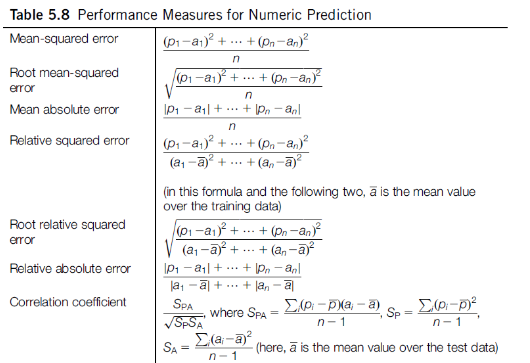

Esta vez no vamos a calcular la precision si no el error que se genera.
Tenemos varias opciones para el calculo del error, nosotros utilizamos la mean squared error (la primera) y la calculamos mediante la libreria de sklearn

In [162]:
from sklearn.metrics import mean_squared_error

def calculaError(conjuntoEjemplos,target,pesos):

    #Dado que aca no estamos clasificando, ya no usamos la funcion clasificar, que basicamente ejecutaba la ejecucion
    #hacia adelante y elegia el max valor. Aca simplemente ejecutamos la red hacia adelante con los ejemplos y pesos
    resultadosClasificacion = ejecutar_adelante(conjuntoEjemplos,pesos)
    #Calculamos error
    error=mean_squared_error(target,resultadosClasificacion["y"])
    return error
     

### Creacion de funcion de Early Stop o Parada Temprana

In [163]:
def earlyStop (xValidacion, tValidacion, pesos, vectorPrecision, ultimoEpoch):

    #Llamamos a la funcion para evaluar la precision con el conjunto de validacion y metemos esta precision al vector de precisiones
    precision = calculaError(xValidacion,tValidacion,pesos)
    vectorPrecision.append(precision)

    #Evaluamos este ultimo valor de precision con el anterior, si es menor, retornamos True, si no, retornamos False
    #Establecemos un valor de tolerancia para que no se detenga el entrenamiento por una diferencia minima (oscilaciones)
    TOLERANCIA = 20 #Esto quiere decir que tienen que haber pasado 20*N epochs para que se detenga el entrenamiento
    if len(vectorPrecision)>TOLERANCIA:
        if vectorPrecision[-1]>vectorPrecision[-2]:
            print("Se detuvo el entrenamiento en el epoch: ",ultimoEpoch)
            return True
        else:
            return False

### Funcion de train

Separamos la funcion de train del resto del codigo base para poder declarar la funcion de earlyStop antes

In [164]:
# x: n entradas para cada uno de los m ejemplos(nxm)
# t: salida correcta (target) para cada uno de los m ejemplos (m x 1)
# pesos: pesos (W y b)
def train(x, t, pesos, learning_rate, epochs, xValidacion, tValidacion, validationEpoch):
    
    # Cantidad de filas --> Esta es la cantidad de ejemplos
    m = np.size(x, 0)

    #Definimos el vector de precision
    vectorPrecision=[] 
    
    for i in range(epochs):
        # Ejecucion de la red hacia adelante
        resultados_feed_forward = ejecutar_adelante(x, pesos)
        y = resultados_feed_forward["y"]
        h = resultados_feed_forward["h"]
        z = resultados_feed_forward["z"]

        # Funcion de perdida (LOSS)
        #Ahora vamos a trabar con la funcion de Loss MSE (es mejor para regresion) y no con Softmax (mejor para clasificacion)
        loss=np.sum((t - y)**2)/m #Loss prom
        

        # Mostramos solo cada 1000 epochs
        if i %1000 == 0:
            print("Loss epoch", i, ":", loss)


        # Extraemos los pesos a variables locales
        w1 = pesos["w1"]
        b1 = pesos["b1"]
        w2 = pesos["w2"]
        b2 = pesos["b2"]

        # Ajustamos los pesos: Backpropagation
        #Modificamos la derivadas para usar MSE y no Softmax

        dL_dy = (2/m)*(y - t)  #Derivando L respecto de y obtenemos esta formula. Ojo aca el signo (regla cadena)            
        

        dL_dw2 = h.T.dot(dL_dy)                         # Ajuste para w2
        dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)   # Ajuste para b2

        dL_dh = dL_dy.dot(w2.T)
        
        dL_dz = dL_dh       # El calculo dL/dz = dL/dh * dh/dz. La funcion "h" es la funcion de activacion de la capa oculta,
        dL_dz[z <= 0] = 0   # para la que usamos ReLU. La derivada de la funcion ReLU: 1(z > 0) (0 en otro caso)

        dL_dw1 = x.T.dot(dL_dz)                         # Ajuste para w1
        dL_db1 = np.sum(dL_dz, axis=0, keepdims=True)   # Ajuste para b1

        # Aplicamos el ajuste a los pesos
        w1 += -learning_rate * dL_dw1
        b1 += -learning_rate * dL_db1
        w2 += -learning_rate * dL_dw2
        b2 += -learning_rate * dL_db2

        # Actualizamos la estructura de pesos
        # Extraemos los pesos a variables locales
        pesos["w1"] = w1
        pesos["b1"] = b1
        pesos["w2"] = w2
        pesos["b2"] = b2

        #Evaluamos si nos encontramos en el epoch de validacion
        if i % validationEpoch == 0:
            #Llamamos a la funcion de parada temprana, la cual nos entrega un booleano
            #Le pasamos el conjunto de validacion, target de validacion, pesos, vector de prescion y numero actual de epoch (i)
            flagEarlyStop = earlyStop(xValidacion, tValidacion, pesos, vectorPrecision,i)
        
        #Si el flag de parada temprana es True, paramos el entrenamiento, si no seguimos con el bucle for normalmente
        if flagEarlyStop:
            break
    
    #Entregamos los nuevos pesos
    nuevosPesos = pesos
    return nuevosPesos

### Funcion Iniciar

Movemos la funcion iniciar aqui, de esta manera podemos ejecutar la funcion que acabamos de crear sin problema

In [165]:
def iniciar(numero_ejemplos, graficar_datos):
    
    # Generamos datos del conjunto train
    x, t = generaradorContinuo(numero_ejemplos)

    #Generamos datos del conjunto test con el mismo numero de ejemplos y clases
    xTest,tTest = generaradorContinuo(numero_ejemplos)

    #Generamos datos del conjunto de validacion con el mismo numero de eje,plos y clases

    xValidacion,tValidacion = generaradorContinuo(numero_ejemplos)

    # Graficamos los datos si es necesario
    if graficar_datos:
        # Parametro: "c": color (un color distinto para cada clase en t)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], t, c=t, cmap='seismic', linewidth=0.5)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('t')
        ax.set_title('Datos de entrenamiento')
        plt.show()

    # Inicializa pesos de la red
    NEURONAS_CAPA_OCULTA = 100
    NEURONAS_ENTRADA = 2 #Son 2 porque tenemos una por cada coordenada
    NEURONAS_SALIDA = 1 #Es 1 porque tenemos solo el valor de t=f(x1,x2)
    pesos = inicializar_pesos(n_entrada=NEURONAS_ENTRADA, n_capa_2=NEURONAS_CAPA_OCULTA, n_capa_3=NEURONAS_SALIDA)

    # Entrenamos a la red. Le pasamos los conjuntos de train y validacion (para parada temprana)
    LEARNING_RATE=0.01
    EPOCHS=10000
    VALIDATION_EPOCH=100 #Cada cuantas epochs hacemos el cross validation con el conjunto de validacion para la early stop
    nuevosPesos=train(x, t, pesos, LEARNING_RATE, EPOCHS, xValidacion, tValidacion, VALIDATION_EPOCH)

    #Calculamos precision de la red para el conjunto train y para el conjunto test
    errorTrain=calculaError(x, t, nuevosPesos)
    print("El Mean squared error en conjunto de Train: "+str(errorTrain)+"%")
    errorTest=calculaError(xTest, tTest, nuevosPesos)
    print("El Mean squared error en conjunto de Test: "+str(errorTest)+"%")

### Experimentacion con cambios de parametros en Generador por default

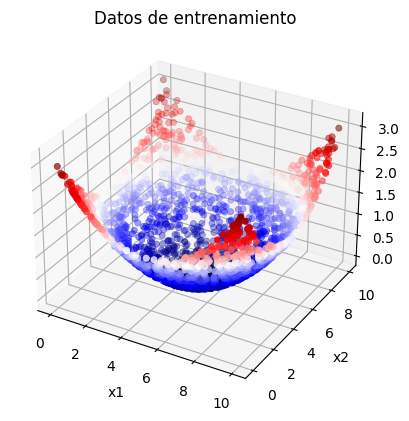

Loss epoch 0 : 4.239861878422289
Loss epoch 1000 : 0.20962178815569557
Loss epoch 2000 : 0.09903460961572773
Loss epoch 3000 : 0.04277393074781067
Se detuvo el entrenamiento en el epoch:  3500
El Mean squared error en conjunto de Train: 0.03314147350067707%
El Mean squared error en conjunto de Test: 0.03439720813337475%


In [166]:
iniciar(2000,True)